Importing the required liabraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math
import random
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook

Importing the dataset

In [2]:
dataset = pd.read_csv("../input/contest1likeordislike/train.csv")
features = ["Brand", "Capacity", "Network Support", "Operating System", "Screen Size", "Internal Memory", "RAM", "VoLTE"]     # 8 features selected
X_train = dataset[features]
y_train = dataset[["Rating"]]
X_test = pd.read_csv("../input/contest1likeordislike/test.csv")[features]
total_dataset = pd.concat([X_train, X_test], ignore_index=True)

Cleaning the dataset

In [3]:
#############################
# Filling out the missing values
#############################
# Remove columns containing nan in Brand
X_train.isnull().sum()
X_test.isnull().sum()
total_dataset = total_dataset.drop(5)

# Filling missing values in Operating System
total_dataset.isnull().sum()
total_dataset["Operating System"] = total_dataset["Operating System"].fillna("Android v8.1 (Oreo)")

# Filling missing values in VoLTE
total_dataset["VoLTE"] = total_dataset["VoLTE"].fillna("no")

#############################
# Encoding the categorical data
#############################
# Encoding the brands
labelcoder = LabelEncoder()
total_dataset["Brand"] = labelcoder.fit_transform(total_dataset["Brand"])

# Encoding the Network Support
labelcoder2 = LabelEncoder()
total_dataset[["Network Support"]] = labelcoder2.fit_transform(total_dataset[["Network Support"]])

# Encoding the Operating System
labelcode3 = LabelEncoder()
total_dataset[["Operating System"]] = labelcode3.fit_transform(total_dataset[["Operating System"]])

# Getting the capacity values
total_dataset["Capacity"] = total_dataset["Capacity"].str.rstrip(" mAh")
total_dataset["Capacity"] = total_dataset["Capacity"].astype(int)

# Getting the Screen Size value
for index, row in total_dataset.iterrows():
    total_dataset.at[index, "Screen Size"] = row["Screen Size"].split(" ")[0]
total_dataset["Screen Size"] = total_dataset["Screen Size"].astype(float)


# Encoding VoLTE
labelcoder4 = LabelEncoder()
total_dataset[["VoLTE"]] = labelcoder4.fit_transform(total_dataset[["VoLTE"]])

# Getting the Internal Memory
total_dataset["Internal Memory"] = total_dataset["Internal Memory"].fillna("Random")
for index, row in total_dataset.iterrows():
    if (row['Internal Memory'].split(" ")[0] == "Random"):
        total_dataset.at[index, 'Internal Memory'] = 0
    else:
        total_dataset.at[index, 'Internal Memory'] = row['Internal Memory'].split(" ")[0]
total_dataset['Internal Memory'] = total_dataset['Internal Memory'].astype(float)
total_dataset['Internal Memory'] = total_dataset['Internal Memory'].replace(0, 32)

# Getting the RAM
total_dataset["RAM"] = total_dataset["RAM"].fillna("Random")
for index, row in total_dataset.iterrows():
    if (row['RAM'].split(" ")[0] == "Random"):
        total_dataset.at[index, 'RAM'] = float(0)
    else:
        if(row['RAM'].split(" ")[1] == "MB"):
            total_dataset.at[index, 'RAM'] = float(row['RAM'].split(" ")[0])/1024
        else:
            total_dataset.at[index, 'RAM'] = float(row['RAM'].split(" ")[0])
total_dataset["RAM"] = total_dataset["RAM"].astype(float)
total_dataset['RAM'] = total_dataset['RAM'].replace(0, 4)

#############################
# Encoding the results
#############################
# Deleting row 5
y_train = y_train.drop(5)

# Encoding the rating
for index, row in y_train.iterrows():
    if(row["Rating"] >= 4):
        y_train.at[index, "Rating"] = 1
    else:
        y_train.at[index, "Rating"] = 0
        
#############################
# Splitting data back into train and test set
#############################
X_train = total_dataset.iloc[:354, :]
X_test = total_dataset.iloc[354:, :]

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Scaling of dataset elements

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
bias1 = np.ones((354, 1))
X_train = np.append(bias1, X_train, axis=1)
X_test = scaler.transform(X_test)
bias2 = np.ones((119, 1))
X_test = np.append(bias2, X_test, axis = 1)

Splitting into Training, Validation and Testing sets

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.25, random_state =1, stratify = y_train)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 1, stratify = y_test)
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [6]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape, X_test.shape)

(265, 9) (265, 1) (45, 9) (45, 1) (44, 9) (44, 1) (119, 9)


In [7]:
class NeuralNetwork:
    def __init__(self, hidden1_size):
        self.hidden1_size = hidden1_size
        self.w1 = np.random.randn(hidden1_size, 9)
        self.w2 = np.random.randn(1, hidden1_size+1)
        self.a1 = np.ones(hidden1_size+1)
        self.a2 = None
    def Sigmoid(self, x):
        s = 1 + math.exp(-x)
        s = 1/s
        return s
    def model(self, x):
        for i in range(self.hidden1_size):
            self.a1[i] = self.Sigmoid(np.dot(self.w1[i], x))
        self.a2 = self.Sigmoid(np.dot(self.w2, self.a1))
        return self.a2
    def predict(self, X):
        y = []
        for x in X:
            y_pred = 1 if self.model(x)>=0.5 else 0
            y.append(y_pred)
        return y
    def Loss(self, y_pred, y):
        loss = y*np.log(y_pred) + (1 - y)*np.log(1 - y_pred)
        return loss
    def fit(self, X, Y, epochs, lr, size):
        loss_matrix = []
        acc_matrix = []
        acc_val_matrix = []
        for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
            loss = 0
            for x, y in zip(X, Y):
                self.a2 = self.model(x)
                y_hat = self.a2
                loss = loss + self.Loss(y_hat, y)
                for i in range(self.hidden1_size+1):
                    self.w2[0, i] = self.w2[0, i] - lr*(y_hat - y)*self.a1[i]
                for i in range(self.hidden1_size):
                    for j in range(9):
                        self.w1[i, j] = self.w1[i, j] - lr*(y_hat - y)*self.w2[0, i]*self.a1[i]*(1 - self.a1[i])*x[j]
            loss_matrix.append(-loss[0]/size)
            acc = accuracy_score(self.predict(X), Y)
            acc_val = accuracy_score(self.predict(x_val), y_val)
            acc_matrix.append(acc)
            acc_val_matrix.append(acc_val)
        plt.plot(loss_matrix, 'r-')
        plt.plot(acc_matrix, 'b-')
        plt.plot(acc_val_matrix, 'g-')
        print('Loss before training: ', loss_matrix[0])
        print('Loss after training: ', loss_matrix[-1])
        print('Accuracy before training: ', acc_matrix[0])
        print('Accuracy after training: ', acc_matrix[-1])

In [8]:
fn = NeuralNetwork(10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Loss before training:  0.6606517604415721
Loss after training:  0.2954498229755198
Accuracy before training:  0.6981132075471698
Accuracy after training:  0.8905660377358491


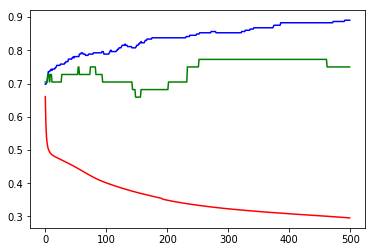

In [9]:
ans = fn.fit(x_train, y_train, 500, 0.024, 283)

Validation Set Score

In [10]:
print("Validation Set Accuracy : "+str(accuracy_score(fn.predict(x_val), y_val)))

Validation Set Accuracy : 0.75


Test Set Score

In [11]:
print("Test Set Accuracy : "+str(accuracy_score(fn.predict(x_test), y_test)))

Test Set Accuracy : 0.7555555555555555


Submission file creation

In [12]:
submission = fn.predict(X_test)
submission = pd.DataFrame(submission)
phone_id = pd.read_csv("../input/contest1likeordislike/test.csv")
phone_id = phone_id["PhoneId"]
submission = pd.concat([phone_id, submission], axis = 1)
submission.to_csv("submission3.csv", header = ["PhoneId", "Class"], index = False)